In [1]:
%load_ext dotenv
%dotenv -o

import os
not not os.environ["POLYGON_API_KEY"]

True

In [2]:
from zipline_polygon_bundle.config import PolygonConfig
from zipline_polygon_bundle import date_to_path, trades_schema, cast_trades, custom_aggs_schema, custom_aggs_partitioning, generate_csv_trades_tables, trades_to_custom_aggs
from zipline_polygon_bundle import get_custom_aggs_dates

from typing import Iterator, Tuple

import pandas as pd
import plotly.graph_objs as go

import pyarrow as pa
from pyarrow import dataset as pa_ds
from pyarrow import compute as pa_compute
from pyarrow import parquet as pa_parquet

from fsspec.implementations.arrow import ArrowFSWrapper

import os

import datetime
import pandas_market_calendars
import numpy as np

import resource

from itables import show

In [3]:
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

374192

In [4]:
resource.getrusage(resource.RUSAGE_SELF)

resource.struct_rusage(ru_utime=3.480576, ru_stime=1.456659, ru_maxrss=374192, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=68067, ru_majflt=0, ru_nswap=0, ru_inblock=0, ru_oublock=264, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=1756, ru_nivcsw=189)

In [5]:
if not "CUSTOM_ASSET_FILES_DIR" in os.environ:
    os.environ["CUSTOM_ASSET_FILES_DIR"]= "/home/jovyan/data"

config = PolygonConfig(
    environ=os.environ,
    calendar_name="NYSE",
    start_date="2021-01-01",
    end_date="2021-01-08",
    agg_time="1min",
)

pd.set_option('display.width', 250)

print(f"{config.minute_aggs_dir=}")
print(f"{config.trades_dir=}")
print(f"{config.custom_aggs_dir=}")
print(f"{config.aggs_dir=}")
print(f"{config.by_ticker_dir=}")

config.minute_aggs_dir='/media/mirror/files.polygon.io/flatfiles/us_stocks_sip/minute_aggs_v1'
config.trades_dir='/media/mirror/files.polygon.io/flatfiles/us_stocks_sip/trades_v1'
config.custom_aggs_dir='/home/jovyan/data/60sec_aggs'
config.aggs_dir='/home/jovyan/data/60sec_aggs'
config.by_ticker_dir='/home/jovyan/data/60sec_aggs_by_ticker'


In [6]:
aggs_ds = pa_ds.dataset(config.custom_aggs_dir, format="parquet", schema=custom_aggs_schema(), partitioning=custom_aggs_partitioning())
# aggs_ds = pa_ds.dataset(config.custom_aggs_dir, format="parquet", partitioning=custom_aggs_partitioning())
aggs_ds

In [19]:
aggs_ds.partition_expression

<pyarrow.compute.Expression true>

In [20]:
pa_ds.get_partition_keys(aggs_ds.partition_expression)

{}

In [ ]:
for fragment in aggs_ds.get_fragments():
    print(f"{fragment.partition_expression=}")
    print(f"{pa_ds.get_partition_keys(fragment.partition_expression)=}")
    # print(f"{fragment.partition_expression.get_partition_values()=}")
    # print(f"{fragment.physical_schema=}")


In [ ]:
set([pa_ds.get_partition_keys(fragment.partition_expression).get("date") for fragment in aggs_ds.get_fragments()])

In [12]:
for fragment in aggs_ds.get_fragments():
    if pa_ds.get_partition_keys(fragment.partition_expression).get("date") is None:
        print(f"{fragment=}")

fragment=<pyarrow.dataset.ParquetFileFragment path=/home/jovyan/data/60sec_aggs/part-0.parquet>


In [ ]:
get_custom_aggs_dates(config)

In [ ]:
set([(date.year, date.month) if date else None for date in get_custom_aggs_dates(config)])

In [ ]:
set([(date.year, date.month) for date in get_custom_aggs_dates(config)])

In [19]:
for fragment in aggs_ds.get_fragments():
    print(f"{fragment.partition_expression=}")
    print(f"{pa_ds.get_partition_keys(fragment.partition_expression)=}")
    # print(f"{fragment.physical_schema=}")
    table = fragment.to_table()
    # print(f"{table.slice(length=1)=}")
    # print(f"{table.schema=}")
    # print(f"{table=}")
    df = table.to_pandas()
    df['window_start'] = df['window_start'].dt.tz_convert('EST')
    df.info()
    print(f"{df['window_start'].min()=}")
    print(f"{df['window_start'].max()=}")
    print(df)
    print()

fragment.partition_expression=<pyarrow.compute.Expression (((year == 2017) and (month == 1)) and (date == 2017-01-03))>
pa_ds.get_partition_keys(fragment.partition_expression)={'date': datetime.date(2017, 1, 3), 'month': 1, 'year': 2017}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1545399 entries, 0 to 1545398
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype              
---  ------        --------------    -----              
 0   ticker        1545399 non-null  object             
 1   volume        1545399 non-null  int64              
 2   open          1545399 non-null  float64            
 3   close         1545399 non-null  float64            
 4   high          1545399 non-null  float64            
 5   low           1545399 non-null  float64            
 6   window_start  1545399 non-null  datetime64[ns, EST]
 7   transactions  1545399 non-null  int64              
dtypes: datetime64[ns, EST](1), float64(4), int64(2), object(1)
memory usage: 94

In [7]:
fragments = aggs_ds.get_fragments()
fragment = next(fragments)
table = fragment.to_table()
aggs_df = table.to_pandas()
aggs_df

ArrowInvalid: Could not open Parquet input source '/home/jovyan/data/60sec_aggs/year=2019/month=1/date=2019-01-02/part-0.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

In [14]:
table = pa_parquet.read_table('/home/jovyan/data/60sec_aggs/year=2022/month=3/date=2022-03-18/part-0.parquet')
table

pyarrow.Table
ticker: string not null
window_start: timestamp[ns, tz=UTC]
open: double
high: double
low: double
close: double
volume: int64
transactions: int64
year: dictionary<values=int32, indices=int32, ordered=0>
month: dictionary<values=int32, indices=int32, ordered=0>
date: dictionary<values=string, indices=int32, ordered=0>
----
ticker: [["ODFL","ODP","OEC","OEF","OEG",...,"QSI","QSR","QTAP","QTEC","QTEK"],["MTEST.A","PTEST.A","ATEST.A","CTEST.A","MTEST.A",...,"BTU","BTX","BUD","BULZ","BWA"],...,["LVS","MBII","ME","MELI","METX",...,"CTK","CUEN","CVX","CWEB","DAL"],["ARKX","ARLO","ARMK","ARNC","AROC",...,"DALN","DAN","DAO","DAPP","DAR"]]
window_start: [[2022-03-18 13:34:00.000000000Z,2022-03-18 13:34:00.000000000Z,2022-03-18 13:34:00.000000000Z,2022-03-18 13:34:00.000000000Z,2022-03-18 13:34:00.000000000Z,...,2022-03-18 13:40:00.000000000Z,2022-03-18 13:40:00.000000000Z,2022-03-18 13:40:00.000000000Z,2022-03-18 13:40:00.000000000Z,2022-03-18 13:40:00.000000000Z],[2022-03-18 05:30

In [38]:
aggs_df = table.to_pandas()
# aggs_df['window_start'] = aggs_df['window_start'].dt.tz_convert('US/Eastern')
aggs_df.set_index(['ticker', 'window_start'], inplace=True)
aggs_df.sort_index(inplace=True)
aggs_df

open      high       low     close  volume  transactions  year month        date
ticker window_start                                                                                                   
A      2022-03-18 11:15:00+00:00  136.8000  136.8000  136.8000  136.8000       5             1  2022     3  2022-03-18
       2022-03-18 12:02:00+00:00  136.8200  136.8200  136.8200  136.8200       3             3  2022     3  2022-03-18
       2022-03-18 12:25:00+00:00  136.0500  137.2400  136.0500  136.3000      35             6  2022     3  2022-03-18
       2022-03-18 12:34:00+00:00  136.3000  136.8200  136.3000  136.8200       2             2  2022     3  2022-03-18
       2022-03-18 13:28:00+00:00  136.1100  136.1100  136.1100  136.1100       1             1  2022     3  2022-03-18
...                                    ...       ...       ...       ...     ...           ...   ...   ...         ...
ZYXI   2022-03-18 20:22:00+00:00    6.0700    6.0700    6.0700    6.0700      20             1  2022     3  2022-03-18
       2022-03-18 20:33:00+00:00    5.7800    5.7800    5.7800    5.7800       9             1  2022     3  2022-03-18
       2022-03-18 23:46:00+00:00    5.8099    5.8099    5.8099    5.8099     610             1  2022     3  2022-03-18
       2022-03-18 23:52:00+00:00    5.8000    5.8000    5.8000    5.8000     232             1  2022     3  2022-03-18
       2022-03-18 23:56:00+00:00    5.7900    5.7900    5.7900    5.7900     170             2  2022     3  2022-03-18

[2368970 rows x 9 columns]

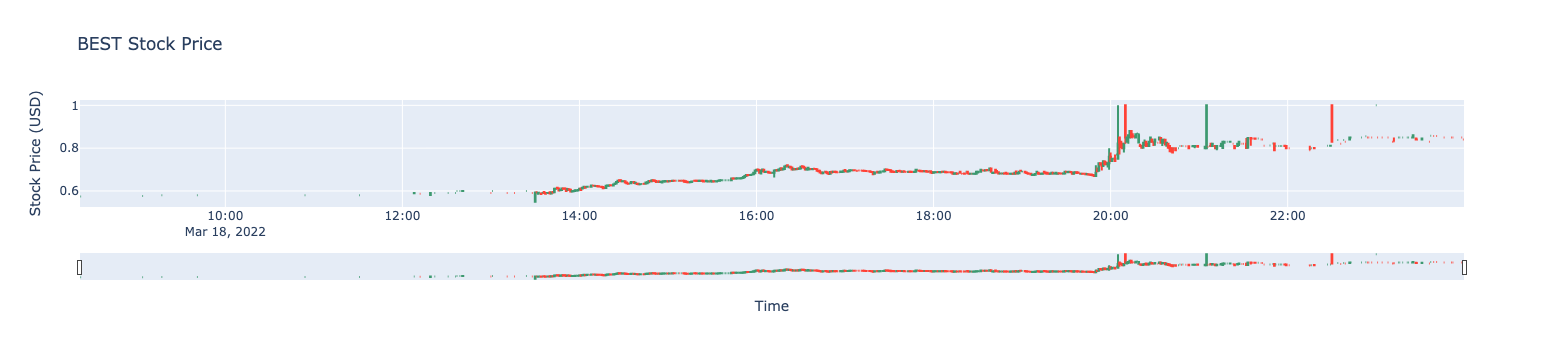

In [39]:
ticker = 'BEST'

best_df = aggs_df.loc[(ticker)]

# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(x=best_df.index,
                                     open=best_df['open'],
                                     high=best_df['high'],
                                     low=best_df['low'],
                                     close=best_df['close'],
                                     name='Stock Data')])

# Add titles and labels
fig.update_layout(title=f'{ticker} Stock Price',
                  yaxis_title='Stock Price (USD)',
                  xaxis_title='Time',
                  xaxis_rangeslider_visible=True)

# Show the figure
fig.show()

In [6]:
table_gen = generate_csv_trades_tables(config)

In [7]:
date, trades_table = next(table_gen)
date, trades_table

(datetime.date(2021, 1, 4),
 pyarrow.Table
 ticker: string not null
 conditions: string not null
 correction: string not null
 exchange: int8 not null
 id: string not null
 participant_timestamp: timestamp[ns, tz=UTC] not null
 price: double not null
 sequence_number: int64 not null
 sip_timestamp: timestamp[ns, tz=UTC] not null
 size: int64 not null
 tape: int8 not null
 trf_id: int64 not null
 trf_timestamp: timestamp[ns, tz=UTC] not null
 ----
 ticker: [["A","A","A","A","A",...,"A","A","A","A","A"],["A","A","A","A","A",...,"AA","AA","AA","AA","AA"],...,["ZVO","ZVO","ZVO","ZVO","ZVO",...,"ZYNE","ZYNE","ZYNE","ZYNE","ZYNE"],["ZYNE","ZYNE","ZYNE","ZYNE","ZYNE",...,"ZYXI","ZYXI","ZYXI","ZYXI","ZYXI"]]
 conditions: [["12,37","12,37","12,37","12,37","12,37",...,"37","14,41","14,37,41","14,41","14,37,41"],["14,37,41","14,37,41","14,37,41","14,37,41","14,41",...,"","","14,41","14,41","14,37,41"],...,["37","37","","","37",...,"37","37","37","14,37,41","37"],["","37","37","37","37",...,"12,37

In [8]:
aggs_table = trades_to_custom_aggs(config, date, trades_table)
aggs_table

date=datetime.date(2021, 1, 4) pa.total_allocated_bytes()=6924336192
mp.backend_name='mimalloc' mp=<pyarrow.MemoryPool backend_name=mimalloc bytes_allocated=6924336192 max_memory=6931781696>
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss=7806996


pyarrow.Table
ticker: string not null
window_start: timestamp[ns, tz=UTC]
open: double
high: double
low: double
close: double
size_sum: int64
transactions: int64
----
ticker: [["CTEST.A","MTEST.A","PTEST.A","ATEST.A","CTEST.A",...,"ZOM","ZROZ","ZSL","ZTEST","ZTST"]]
window_start: [[2021-01-04 06:30:00.000000000Z,2021-01-04 06:30:00.000000000Z,2021-01-04 06:30:00.000000000Z,2021-01-04 06:31:00.000000000Z,2021-01-04 06:31:00.000000000Z,...,2021-01-05 01:00:00.000000000Z,2021-01-05 01:00:00.000000000Z,2021-01-05 01:00:00.000000000Z,2021-01-05 01:00:00.000000000Z,2021-01-05 01:00:00.000000000Z]]
open: [[10.604894,14.720926,10.593358,12.645032,14.515077,...,0.35,162.67,6.41,10.1,40.17]]
high: [[11.510764,14.720926,12.273018,14.552261,14.515077,...,0.35,162.67,6.41,10.1,40.17]]
low: [[10.604894,14.720926,10.593358,10.854299,11.478276,...,0.35,162.67,6.41,10.1,40.17]]
close: [[11.510764,14.720926,12.273018,10.854299,11.556036,...,0.35,162.67,6.41,10.1,40.17]]
size_sum: [[222,111,222,666,444,.

In [10]:
aggs_df = aggs_table.slice(length=1000).to_pandas()
show(aggs_df)

In [10]:
len(trades_table)

76084591

In [12]:
tt = trades_table.append_column('foo', pa.array([123] * len(trades_table)))
tt

pyarrow.Table
ticker: string not null
conditions: string not null
correction: string not null
exchange: int8 not null
id: string not null
participant_timestamp: timestamp[ns, tz=UTC] not null
price: double not null
sequence_number: int64 not null
sip_timestamp: timestamp[ns, tz=UTC] not null
size: int64 not null
tape: int8 not null
trf_id: int64 not null
trf_timestamp: timestamp[ns, tz=UTC] not null
foo: int64
----
ticker: [["A","A","A","A","A",...,"A","A","A","A","A"],["A","A","A","A","A",...,"AA","AA","AA","AA","AA"],...,["ZVO","ZVO","ZVO","ZVO","ZVO",...,"ZYNE","ZYNE","ZYNE","ZYNE","ZYNE"],["ZYNE","ZYNE","ZYNE","ZYNE","ZYNE",...,"ZYXI","ZYXI","ZYXI","ZYXI","ZYXI"]]
conditions: [["12,37","12,37","12,37","12,37","12,37",...,"37","14,41","14,37,41","14,41","14,37,41"],["14,37,41","14,37,41","14,37,41","14,37,41","14,41",...,"","","14,41","14,41","14,37,41"],...,["37","37","","","37",...,"37","37","37","14,37,41","37"],["","37","37","37","37",...,"12,37","12,37","12,37","12,37","12,37"]